# Modeling

In [3]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
%%time
vars_all = pd.read_csv('2_df_final_with_Y.csv').sort_values("Recnum").reset_index(drop=True)
vars_all.rename(columns={'Recnum':'Recnum'},inplace=True)
vars_all.rename(columns={'Fraud':'Fraud'},inplace=True)

print(vars_all.shape)
vars_all.head()

(96397, 27)
CPU times: total: 109 ms
Wall time: 263 ms


,card_Merch_num_state_total_14,card_Merchnum_max_30,card_Merch_des_zip_total_1,Merch_description_total_0,card_Merch_state_zip_total_14,card_Merch_des_state_max_30,card_Merch_des_zip_max_30,card_Merch_des_state_zip_max_30,card_Merch_num_des_zip_total_0,card_Merch_des_state_zip_total_30,...,Merch_state_zip_variability_avg_14,card_Merch_num_des_total_0,card_Merch_des_state_total_30,card_Merch_des_state_total_0,card_Merch_description_total_0,card_Merch_zip_total_0,card_Merch_num_des_zip_total_14,card_Merch_description_total_30,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,0.0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,0.0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,7.24,7.24,3.62,3.62,3.62,7.24,7.24,...,0.0,7.24,7.24,7.24,7.24,7.24,7.24,7.24,5,0


### NVAR

In [5]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10
numvars = min(NVARS,len(vars_all)-2) # 10
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars_all.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_Merch_num_state_total_14',
 'card_Merchnum_max_30',
 'card_Merch_des_zip_total_1',
 'Merch_description_total_0',
 'card_Merch_state_zip_total_14',
 'card_Merch_des_state_max_30',
 'card_Merch_des_zip_max_30',
 'card_Merch_des_state_zip_max_30',
 'card_Merch_num_des_zip_total_0',
 'card_Merch_des_state_zip_total_30']

In [6]:
vars = vars_all.filter(final_vars_list,axis=1)

In [7]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [8]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_Merch_num_state_total_14,card_Merchnum_max_30,card_Merch_des_zip_total_1,Merch_description_total_0,card_Merch_state_zip_total_14,card_Merch_des_state_max_30,card_Merch_des_zip_max_30,card_Merch_des_state_zip_max_30,card_Merch_num_des_zip_total_0,card_Merch_des_state_zip_total_30
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,770.509236,517.704051,593.666588,761.885095,803.336711,514.700728,513.497615,513.491474,523.805769,903.627845
std,4168.658888,1084.028924,4010.097366,2872.816671,4185.964751,1074.829349,1074.519504,1074.520672,2616.296248,4312.348251
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.090000,53.430000,45.900000,66.850000,84.450000,49.100000,48.850000,48.850000,43.350000,63.500000
50%,237.210000,201.050000,162.740000,225.000000,255.000000,200.550000,200.000000,200.000000,155.000000,246.750000
75%,678.000000,597.510000,509.320000,735.000000,713.010000,595.000000,593.230000,593.230000,490.860000,796.000000
max,306633.410000,47900.000000,306633.410000,217467.180000,306633.410000,47900.000000,47900.000000,47900.000000,217467.180000,306633.410000


In [9]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

# use this to cap variables. For some problems it helps
Clip = 10

# push in any outlier values, then rescale
X.clip(-1*Clip, Clip, inplace=True)

# Now redo the zscaling after clipping
X = (X - X.mean()) / X.std()
X.describe()

,card_Merch_num_state_total_14,card_Merchnum_max_30,card_Merch_des_zip_total_1,Merch_description_total_0,card_Merch_state_zip_total_14,card_Merch_des_state_max_30,card_Merch_des_zip_max_30,card_Merch_des_state_zip_max_30,card_Merch_num_des_zip_total_0,card_Merch_des_state_zip_total_30
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,1.632861e-15,-2.943088e-16,-3.105266e-15,9.543076e-16,2.475414e-16,-1.357099e-15,-3.832563e-15,3.024862e-15,-5.718466e-16,1.812779e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.531577e-01,-6.064073e-01,-3.173814e-01,-4.352501e-01,-3.623744e-01,-6.023596e-01,-6.012590e-01,-6.012505e-01,-3.933519e-01,-3.649256e-01
25%,-3.153007e-01,-5.422421e-01,-2.905632e-01,-3.953644e-01,-3.216869e-01,-5.434950e-01,-5.426602e-01,-5.426519e-01,-3.587629e-01,-3.377712e-01
50%,-2.366597e-01,-3.649292e-01,-2.222817e-01,-3.009909e-01,-2.395073e-01,-3.618889e-01,-3.613088e-01,-3.613008e-01,-2.696569e-01,-2.593960e-01
75%,-2.017084e-02,1.112766e-01,-1.973979e-02,3.343646e-03,-1.881494e-02,1.111025e-01,1.104928e-01,1.105000e-01,-1.612438e-03,-2.448431e-02
max,2.049914e+01,1.303617e+01,2.346463e+01,1.716247e+01,2.019480e+01,1.290327e+01,1.290703e+01,1.290702e+01,2.090492e+01,1.846526e+01


In [10]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 84299

X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]

X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

In [11]:
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [12]:
try:
    Modeling_output = pd.read_csv('Modeling_output.csv').iloc[:, 1:]
    counter = Modeling_output[Modeling_output['Model'].isnull()].index[0]
    model_counter = len(Modeling_output[['Model', 'NVARS', 'Parameters']].drop_duplicates().dropna(subset='Model'))
    print(counter)
    print(model_counter)

except:
    Modeling_output = pd.DataFrame(columns=['Model', 'NVARS', 'Parameters', 'Trn','Tst','OOT'],index=range(3000))
    counter = 0
    model_counter = 0

Modeling_output

,Model,NVARS,Parameters,Trn,Tst,OOT
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2995,NaN,NaN,NaN,NaN,NaN,NaN
2996,NaN,NaN,NaN,NaN,NaN,NaN
2997,NaN,NaN,NaN,NaN,NaN,NaN
2998,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def model_execution(model_name, algorithm, X, Y, X_oot, Y_oot, test_size = .3, nitermax = 10, Parameters_setting = "",
                    print_bool = True):
    
    global Modeling_output, counter, model_counter, NVARS, output

    FDR3 = pd.DataFrame(np.zeros((nitermax, 3)), columns=('trn', 'tst', 'oot'))
    
    if Parameters_setting == "": Parameters_setting = str(algorithm)
    Parameters_setting = Parameters_setting.replace(' ', '').replace('\n', '').replace(',', ', ')
    Parameters_setting = Parameters_setting.split('(', 1)[1][:-1]
    
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size = test_size)

        model = algorithm

        X_oot_copied = X_oot.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())

        def prediction_function(X_splited, y_splited, name):

            predictions = model.predict_proba(X_splited)[:,1]
            X_splited['predicted'] = predictions
            X_splited['Fraud'] = y_splited['Fraud']
            topRows = int(round(X_splited.shape[0]*0.03))
            temp = X_splited.sort_values('predicted',ascending=False).head(topRows)
            needed = temp.loc[:,'Fraud']
            FDR3.loc[niter, name] = sum(needed)/sum(X_splited.loc[:,'Fraud'])
            
            return X_splited

        X_trn = prediction_function(X_trn, Y_trn_save, 'trn')
        X_tst = prediction_function(X_tst, Y_tst, 'tst')
        X_oot_copied = prediction_function(X_oot_copied, Y_oot, 'oot')

        if print_bool == True: print(niter,
                                     FDR3.loc[niter, 'trn'],
                                     FDR3.loc[niter, 'tst'],
                                     FDR3.loc[niter, 'oot'])

        Modeling_output.iloc[counter] = [model_name,
                                         NVARS,
                                         Parameters_setting,
                                         FDR3.loc[niter, 'trn'],
                                         FDR3.loc[niter, 'tst'],
                                         FDR3.loc[niter, 'oot']]
        counter = counter + 1
        Modeling_output.to_csv('Modeling_output.csv') # KK: save my progress

    if print_bool == True: print(FDR3.mean())
    model_counter = model_counter + 1
    
    df = Modeling_output.dropna()
    output = (df.groupby(['Model', 'NVARS', 'Parameters'])
              .agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']}))
    output = output.sort_values(by=['Model', ('Trn', 'mean'), 'NVARS'])
    
    return output.loc[model_name], {'X_trn': X_trn, 'X_tst': X_tst, 'X_oot': X_oot_copied, 'FDR3': FDR3}

### Random Forest

In [14]:
%%time
# RF
model_execution(model_name = 'RF',
                algorithm = RandomForestClassifier(n_estimators=20, min_impurity_decrease=0.00001,
                                                  min_samples_leaf=30, min_samples_split=60),
                X = X_trntst, Y = Y_trntst,
                X_oot = X_oot_orig, Y_oot = Y_oot)[0]

0 0.780952380952381 0.756 0.553072625698324
1 0.7861952861952862 0.7377622377622378 0.5698324022346368
2 0.8057784911717496 0.7315175097276264 0.5083798882681564
3 0.790893760539629 0.7142857142857143 0.5307262569832403
4 0.806930693069307 0.7226277372262774 0.5586592178770949
5 0.7677725118483413 0.7611336032388664 0.5307262569832403
6 0.791869918699187 0.7056603773584905 0.5195530726256983
7 0.7883096366508688 0.7368421052631579 0.5251396648044693
8 0.78125 0.7426470588235294 0.5586592178770949
9 0.7914012738853503 0.7301587301587301 0.5307262569832403
trn    0.789135
tst    0.733864
oot    0.538547
dtype: float64
CPU times: total: 6.73 s
Wall time: 17.4 s


Trn            \
                                                              mean       std   
NVARS Parameters                                                               
10    min_impurity_decrease=1e-05, min_samples_leaf=3...  0.789135  0.011567   

                                                               Tst            \
                                                              mean       std   
NVARS Parameters                                                               
10    min_impurity_decrease=1e-05, min_samples_leaf=3...  0.733864  0.017189   

                                                               OOT            
                                                              mean       std  
NVARS Parameters                                                              
10    min_impurity_decrease=1e-05, min_samples_leaf=3...  0.538547  0.020091

## Model comparison plots

In [33]:
df = Modeling_output.dropna()
df.head(20)

,Model,NVARS,Parameters,Trn,Tst,OOT
0,log reg,10.0,penalty='none',0.608696,0.671815,0.251397
1,log reg,10.0,penalty='none',0.632166,0.634921,0.346369
2,log reg,10.0,penalty='none',0.625600,0.647059,0.284916
3,log reg,10.0,penalty='none',0.635922,0.622137,0.357542
4,log reg,10.0,penalty='none',0.643087,0.608527,0.279330
5,log reg,10.0,penalty='none',0.631173,0.612069,0.279330
6,log reg,10.0,penalty='none',0.609477,0.671642,0.340782
7,log reg,10.0,penalty='none',0.650641,0.585938,0.307263
8,log reg,10.0,penalty='none',0.608280,0.686508,0.256983
9,log reg,10.0,penalty='none',0.617845,0.615385,0.245810


In [34]:
df.shape

(330, 6)

In [35]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.608696
1,log reg,Trn,0.632166
2,log reg,Trn,0.625600
3,log reg,Trn,0.635922
4,log reg,Trn,0.643087


In [36]:
output = df.groupby(['Model', 'NVARS', 'Parameters']).agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output.reset_index().to_excel('output.xlsx')

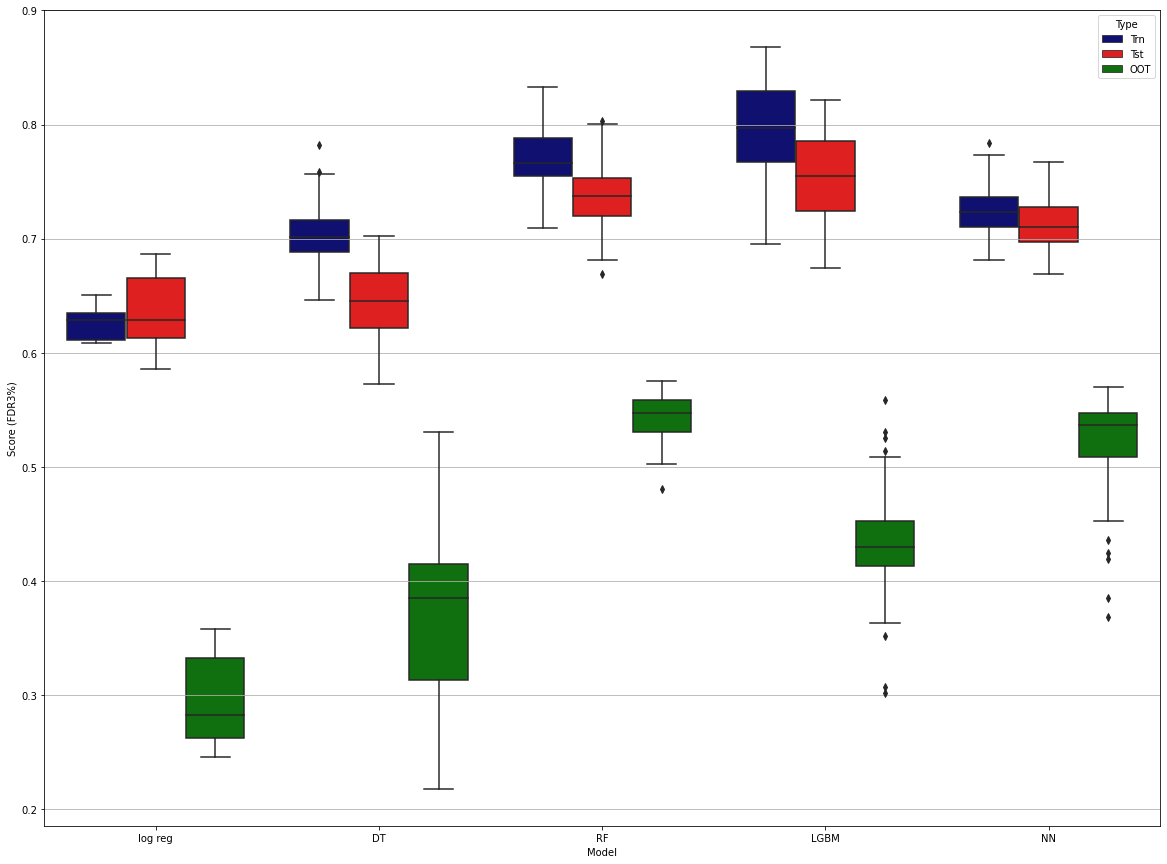

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

# plt.ylim(.4,.6)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

### Final model of choice

In [17]:
%%time
# Final_RF
result_final_model = model_execution(model_name = 'Final_RF',
                                algorithm = RandomForestClassifier(n_estimators=20, min_impurity_decrease=0.00001,
                                                                   min_samples_leaf=30, min_samples_split=60),
                                X = X_trntst, Y = Y_trntst,
                                X_oot = X_oot_orig, Y_oot = Y_oot,
                                nitermax = 30)

0 0.8184764991896273 0.714828897338403 0.547486033519553
1 0.7825370675453048 0.7509157509157509 0.5307262569832403
2 0.7709320695102686 0.8016194331983806 0.547486033519553
3 0.7862838915470495 0.7193675889328063 0.5307262569832403
4 0.7908082408874801 0.7389558232931727 0.5754189944134078
5 0.7859424920127795 0.7559055118110236 0.553072625698324
6 0.7681159420289855 0.7606177606177607 0.5251396648044693
7 0.76049766718507 0.810126582278481 0.5754189944134078
8 0.7816455696202531 0.7701612903225806 0.5083798882681564
9 0.7768729641693811 0.7556390977443609 0.5251396648044693
10 0.7636363636363637 0.7745454545454545 0.5195530726256983
11 0.7867528271405493 0.7662835249042146 0.5418994413407822
12 0.7767441860465116 0.7659574468085106 0.5139664804469274
13 0.7922077922077922 0.7765151515151515 0.5027932960893855
14 0.7877358490566038 0.7663934426229508 0.5418994413407822
15 0.7668231611893583 0.7219917012448133 0.547486033519553
16 0.8025889967637541 0.7175572519083969 0.536312849162011

In [24]:
result_final_model[1]['X_trn'].sort_index()

,card_Merch_num_state_total_14,card_Merchnum_max_30,card_Merch_des_zip_total_1,Merch_description_total_0,card_Merch_state_zip_total_14,card_Merch_des_state_max_30,card_Merch_des_zip_max_30,card_Merch_des_state_zip_max_30,card_Merch_num_des_zip_total_0,card_Merch_des_state_zip_total_30,predicted,Fraud
2,-0.265499,-0.392027,-0.213077,-0.328745,-0.276374,-0.388341,-0.387117,-0.387109,-0.250910,-0.288591,0.001607,0
3,-0.351385,-0.602071,-0.315272,-0.433096,-0.360635,-0.598031,-0.596928,-0.596919,-0.390471,-0.363382,0.001607,0
4,-0.349607,-0.602071,-0.313156,-0.430936,-0.358891,-0.598031,-0.596928,-0.596919,-0.387582,-0.361833,0.001607,0
5,-0.351360,-0.602011,-0.315242,-0.433066,-0.360611,-0.597971,-0.596868,-0.596859,-0.390431,-0.363360,0.001607,0
6,-0.351385,-0.602071,-0.315272,-0.430936,-0.360635,-0.598031,-0.596928,-0.596919,-0.390471,-0.363382,0.001607,0
...,...,...,...,...,...,...,...,...,...,...,...,...
84292,-0.216675,-0.241355,-0.178346,0.627104,-0.228473,-0.237924,-0.236612,-0.236605,-0.203480,-0.116084,0.001607,0
84293,-0.251006,-0.356581,-0.195832,-0.311135,-0.262154,-0.352955,-0.351710,-0.351702,-0.227358,-0.275969,0.001607,0
84294,1.074576,1.889559,0.849663,0.494456,1.038360,1.889392,1.891936,1.891940,0.850055,4.109620,0.008423,0
84295,-0.279492,-0.426248,-0.229727,-0.345746,-0.290102,-0.422504,-0.421299,-0.421291,-0.273647,-0.300776,0.001607,0


In [26]:
X_trn_eval = result_final_model[1]['X_trn'].sort_index().copy()
X_tst_eval = result_final_model[1]['X_tst'].sort_index().copy()
X_oot_eval = result_final_model[1]['X_oot'].sort_index().copy()
FDR3 = result_final_model[1]['FDR3'].copy()

In [27]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']

FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)

trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)

oot_sorted.head(20)

,card_Merch_num_state_total_14,card_Merchnum_max_30,card_Merch_des_zip_total_1,Merch_description_total_0,card_Merch_state_zip_total_14,card_Merch_des_state_max_30,card_Merch_des_zip_max_30,card_Merch_des_state_zip_max_30,card_Merch_num_des_zip_total_0,card_Merch_des_state_zip_total_30,predicted,Fraud
89128,14.420964,3.741580,14.181944,2.880009,14.132361,3.738285,3.741900,3.741901,4.040539,10.246433,0.814870,1
89121,14.190694,3.741580,13.907947,2.600230,13.906445,3.738285,3.741900,3.741901,3.666357,10.045908,0.814870,1
95844,20.499143,13.036173,23.464625,17.162471,20.194804,12.903266,12.907030,12.907021,20.904918,18.465264,0.801871,0
89186,20.023467,9.359033,20.454297,9.284729,19.628917,9.346251,9.353115,9.353106,12.606332,14.836867,0.796252,1
89183,19.928039,9.359033,20.340747,9.168783,19.535293,9.346251,9.353115,9.353106,12.451265,14.753765,0.796252,1
89174,19.095633,9.359033,19.350274,8.157408,18.718629,9.346251,9.353115,9.353106,11.098632,14.028886,0.796252,1
89130,18.680469,9.359033,19.030507,7.830893,18.311316,9.346251,9.353115,9.353106,10.661945,13.794864,0.777537,1
89120,13.384977,3.741580,12.949230,1.621281,13.115964,3.738285,3.741900,3.741901,2.357092,9.344269,0.751468,1
89114,13.007680,3.741580,12.500287,1.162864,12.745802,3.738285,3.741900,3.741901,1.743996,9.015710,0.751468,1
89117,13.210780,3.741580,12.741955,1.409632,12.945062,3.738285,3.741900,3.741901,2.074028,9.192574,0.751468,1


In [28]:
def FDR_eval(dataframe, X):
    
    bad_tot = sum(X.loc[:, 'Fraud'])
    num_tot = len(X)
    good_tot = num_tot - bad_tot
    
    X_sorted = X.sort_values('predicted',ascending=False)

    for i in range(101):

        percent_rows = int(round(X.shape[0]*0.01*i))
        temp = X_sorted.head(percent_rows)
        num_bad = sum(temp.loc[:,'Fraud'])
        num_tot = len(temp)
        num_good = num_tot - num_bad

        dataframe.loc[i, 'bin'] = i
        dataframe.loc[i,'#recs'] = 0
        dataframe.loc[i, 'tot'] = num_tot
        dataframe.loc[i, 'cg'] = num_good # cumulative good
        dataframe.loc[i, 'cb'] = num_bad # cumulative bad

        if i != 0:
            dataframe.loc[i, '#g'] = num_good - dataframe.loc[i-1, 'cg'] # marginal good
            dataframe.loc[i, '#b'] = num_bad - dataframe.loc[i-1, 'cb'] # marginal bad
            dataframe.loc[i,'#recs'] = dataframe.loc[i, '#g'] + dataframe.loc[i, '#b']
            
            dataframe.loc[i, '%g'] = 100 * (dataframe.loc[i, '#g']) / (num_tot - dataframe.loc[i-1, 'tot'])
            dataframe.loc[i, '%b'] = 100 - dataframe.loc[i, '%g']
            
            dataframe.loc[i, '%cg'] = 100 * num_good / good_tot
            dataframe.loc[i, 'FDR'] = 100 * num_bad / bad_tot
            dataframe.loc[i, 'KS'] = dataframe.loc[i, 'FDR'] - dataframe.loc[i, '%cg']
            dataframe.loc[i, 'FPR'] = num_good / num_bad

    return dataframe

In [29]:
FDR_trn = FDR_eval(dataframe = FDR_trn, X = X_trn_eval)
FDR_tst = FDR_eval(dataframe = FDR_tst, X = X_tst_eval)
FDR_oot = FDR_eval(dataframe = FDR_oot, X = X_oot_eval)

In [30]:
FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,59.0,62.0,48.760331,51.239669,121.0,59.0,62.0,0.495008,34.636872,34.141864,0.951613
2,2.0,121.0,101.0,20.0,83.471074,16.528926,242.0,160.0,82.0,1.342394,45.810056,44.467661,1.951220
3,3.0,121.0,106.0,15.0,87.603306,12.396694,363.0,266.0,97.0,2.231731,54.189944,51.958213,2.742268
4,4.0,121.0,115.0,6.0,95.041322,4.958678,484.0,381.0,103.0,3.196577,57.541899,54.345323,3.699029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,121.0,0.0,100.000000,0.000000,11614.0,11442.0,172.0,95.997986,96.089385,0.091399,66.523256
97,97.0,121.0,120.0,1.0,99.173554,0.826446,11735.0,11562.0,173.0,97.004782,96.648045,-0.356738,66.832370
98,98.0,121.0,119.0,2.0,98.347107,1.652893,11856.0,11681.0,175.0,98.003188,97.765363,-0.237825,66.748571
99,99.0,121.0,120.0,1.0,99.173554,0.826446,11977.0,11801.0,176.0,99.009984,98.324022,-0.685962,67.051136


In [62]:
FDR3.to_csv('FDR3.csv')

In [63]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

## Saving Plot

Max possible savings: 20,148,000.0
Max possible cutofff: 4.00%


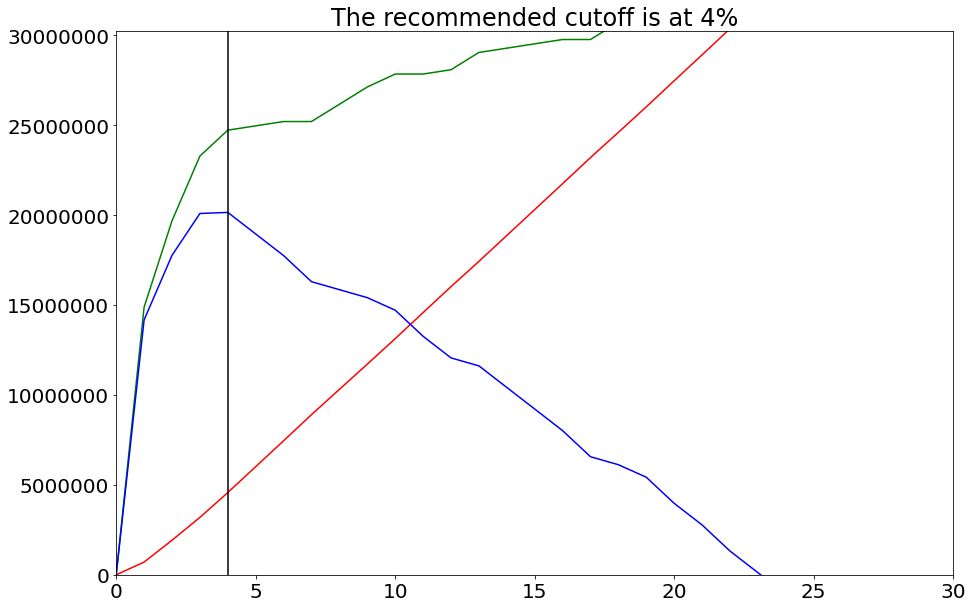

In [65]:
# cost_fraud = 400
# cost_fp = 20

# # xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year

# xoot = 12/2 * 10_000_000/100_000
# Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])

# for i in range(101):
#     Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
#     Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
#     Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
max_cutoff = Financials_oot['Overall Savings'].idxmax()
print('Max possible savings: '+'{:,}'.format(max_savings))
print('Max possible cutofff: '+'{:.2%}'.format(max_cutoff/100))

yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.axvline(x = 4, color = 'black')
plt.ticklabel_format(style='plain')
plt.title("The recommended cutoff is at 4%")
plt.savefig('savings.png', format='png')


In [32]:
print("duration: ", datetime.now() - start_time)

duration:  0:14:53.563369
